In [ ]:
import numpy as np
from scipy import linalg as la
from scipy.stats import linregress
from matplotlib import pyplot as plt


# Auxiliary Functions ---------------------------------------------------------
def starting_point(A, b, c):
    """
    Calculate an initial guess to the solution of the linear program
    min c^T x, Ax = b, x>=0.
    Reference: Nocedal and Wright, p. 410.
    """
    # Calculate x, lam, mu of minimal norm satisfying both
    # the primal and dual constraints.
    B = la.inv(A @ A.T)
    x = A.T @ B @ b
    lam = B @ A @ c
    mu = c - (A.T @ lam)

    # Perturb x and s so they are nonnegative.
    dx = max((-3./2)*x.min(), 0)
    dmu = max((-3./2)*mu.min(), 0)
    x += dx*np.ones_like(x)
    mu += dmu*np.ones_like(mu)

    # Perturb x and mu so they are not too small and not too dissimilar.
    dx = .5*(x*mu).sum()/mu.sum()
    dmu = .5*(x*mu).sum()/x.sum()
    x += dx*np.ones_like(x)
    mu += dmu*np.ones_like(mu)

    return x, lam, mu

# linear program generator to test interior point method 
def randomLP(m,n):
    """
    Generate a linear program min c^T x s.t. Ax = b, x>=0.
    First generate m feasible constraints, then add
    slack variables to convert it into the above form.
    Parameters:
        m -- positive integer >= n, number of desired constraints
        n -- dimension of space in which to optimize
    Returns:
        A -- array of shape (m,n+m)
        b -- array of shape (m,)
        c -- array of shape (n+m,), with m trailing 0s
        v -- the solution to the LP
    """
    A = np.random.random((m,n))*20 - 10
    A[A[:,-1]<0] *= -1
    v = np.random.random(n)*10
    k = n
    b = np.zeros(m)
    b[:k] = A[:k,:].dot(v)
    b[k:] = A[k:,:].dot(v) + np.random.random(m-k)*10
    c = np.zeros(n+m)
    c[:n] = A[:k,:].sum(axis=0)/k
    A = np.hstack((A, np.eye(m)))
    return A, b, -c, v


# interior point function definition
def interiorPoint(A, b, c, niter = 20, tol = 1e-16, verbose = False):
    """
    Solve the linear program: 
    
    min: c^T x
    subject to: Ax = b, x>=0
    
    using an Interior Point method.

    Parameters:
        A ((m,n) ndarray): Equality constraint matrix with full row rank.
        b ((m, ) ndarray): Equality constraint vector.
        c ((n, ) ndarray): Linear objective function coefficients.
        niter (int > 0): The maximum number of iterations to execute.
        tol (float > 0): The convergence tolerance.

    Returns:
        x ((n, ) ndarray): The optimal point.
        val (float): The minimum value of the objective function.
    """ 
    m, n = A.shape # will use these multiple times
    
    def F(x, lmda, mu): 
        """
        Returns KKT conditions for Lagrangian
        """
        return np.concatenate([A.T @ lmda + mu - c , A@x - b, np.diag(mu) @ x])
    
    
    def search_direction(x, lmda, mu): 
        """
        Solves the search-direction problem
        via LU decomposition of matrices  
        """
        sigma = 0.1 # centering parameter 
        e, zeros = np.ones(n), np.zeros(m + n)
        v = (x.T @ mu) / n # duality measure 
        
        # perturbation vector 
        vector = np.concatenate((zeros, e)) * sigma * v
        right = -F(x, lmda, mu) + vector
        
        # diagonalize x, mu to create DF 
        X, M = np.diag(x), np.diag(mu)
        
        # components to create DF 
        top = np.hstack((np.zeros((n, n)), A.T, np.eye(n)))
        mid = np.hstack((A, np.zeros((m, m + n))))
        bottom = np.hstack((M, np.zeros((n, m)), X))
        
        # stack to create DF 
        DF = np.vstack((top, mid, bottom))
        
        # factor with LU and solve 
        L, P = la.lu_factor(DF)
        soln = la.lu_solve((L, P), right)
        
        # divvy up the individual vectors 
        del_x = soln[:n]
        del_lmda = soln[n: n + m]
        del_mu = soln[n + m:]
        
        # return the del's 
        return del_x, del_lmda, del_mu
        
    
    def step_size(x, lmda, mu): 
        """
        Calculate the max-allowable step sizes while still staying
        in the feasible region of the problem 
        """
        # retrieve del's from search direction function 
        del_x, del_lmda, del_mu = search_direction(x, lmda, mu)
        
        # mask where we find appropriate alpha 
        mask = np.where(del_mu < 0)
        a = min(-mu[mask] / del_mu[mask])
        alpha = min(1, 0.95 * a)
        
        # mask where we find appropriate delta 
        mask = np.where(del_x < 0)
        d = min(-x[mask] / del_x[mask])
        delta = min(1, 0.95 * d)
        
        # return the updated step sizes 
        return delta * del_x, alpha * del_lmda, alpha * del_mu
    
    
    # get initial starting point from auxiliary
    x0, lmda0, mu0 = starting_point(A, b, c)
    
    # run optimizer !! 
    for i in range(niter): 
        
        step_x, step_lmda, step_mu = step_size(x0, lmda0, mu0)
        
        x1 = x0 + step_x
        lmda1 = lmda0 + step_lmda
        mu1 = mu0 + step_mu
        
        # update duality measure 
        v = (x1.T @ mu1) / n
        
        print("Iteration {} - Duality Measure {}".format(i, v))
        
        # if duality measure is less than tol
        # in other words, if we are close enough to the optimizer 
        if v < tol: 
            break 
    
        # update our " parameters "
        x0, lmda0, mu0 = x1, lmda1, mu1
       
    # return optimizer x1 and falue given x1 
    return x1, c.T @ x1
        

In [ ]:
m, n = 10, 10
A, b, c, x = randomLP(m, n)
point, value = interiorPoint(A, b, c, niter=200)
verdict = np.allclose(x, point[:n], atol=0.5)
print("\n{} at (m,n)=({},{})".format(verdict, m, n))
if not verdict:
    print("\nm,n = {},{}\n{}\n{}\n".format(m, n, x, point[:n]))

Iteration 0 - Duality Measure 0.07873503954450048
Iteration 1 - Duality Measure 0.009768499816863152
Iteration 2 - Duality Measure 0.0011640732816172322
Iteration 3 - Duality Measure 0.00011640732816172541
Iteration 4 - Duality Measure 1.1640732816172558e-05
Iteration 5 - Duality Measure 1.164073281617254e-06
Iteration 6 - Duality Measure 1.1640732816172551e-07
Iteration 7 - Duality Measure 1.1640732816172518e-08
Iteration 8 - Duality Measure 1.1640732816172535e-09
Iteration 9 - Duality Measure 1.1640732816172601e-10
Iteration 10 - Duality Measure 1.1640732816172523e-11
Iteration 11 - Duality Measure 1.1640732816172565e-12
Iteration 12 - Duality Measure 1.1640732816172576e-13
Iteration 13 - Duality Measure 1.1640732816172507e-14
Iteration 14 - Duality Measure 1.1640732816172506e-15
Iteration 15 - Duality Measure 1.164073281617257e-16
Iteration 16 - Duality Measure 1.1640732816172471e-17

True at (m,n)=(10,10)


In [ ]:
point

array([6.81096791e+00, 5.13684508e+00, 1.89316131e+00, 8.14348230e+00,
       3.15657190e+00, 7.12972570e-01, 8.28568070e+00, 5.36109524e-01,
       9.27460854e+00, 2.17364832e+00, 1.16407328e-16, 1.16407328e-16,
       1.16407328e-16, 1.16407328e-16, 1.16407328e-16, 1.16407328e-16,
       1.16407328e-16, 1.16407328e-16, 1.16407328e-16, 1.16407328e-16])

In [ ]:
value

-52.025095860878544

In [ ]:
def leastAbsoluteDeviations(filename = "simdata.txt"):
    """
    Generate and show the plot requested in the lab
    """
    # read in the data 
    data = np.loadtxt(filename)
    
    # initialize the vectors c and y.
    m = data.shape[0]
    n = data.shape[1] - 1
    c = np.zeros(3*m + 2*(n + 1))
    c[:m] = 1
    y = np.empty(2*m)
    y[::2] = -data[:, 0]
    y[1::2] = data[:, 0]
    x = data[:, 1:]
    
    # initialize constraint matrix 
    A = np.ones((2*m, 3*m + 2*(n + 1)))
    A[::2, :m] = np.eye(m)
    A[1::2, :m] = np.eye(m)
    A[::2, m:m+n] = -x
    A[1::2, m:m+n] = x
    A[::2, m+n:m+2*n] = x
    A[1::2, m+n:m+2*n] = -x
    A[::2, m+2*n] = -1
    A[1::2, m+2*n+1] = -1
    A[:, m+2*n+2:] = -np.eye(2*m, 2*m)
    
    # solve the interior point problem 
    sol = interiorPoint(A, y, c, niter = 20)[0]
    
    # calculate beta - slope and b - intercept for LAD 
    beta = sol[m:m+n] - sol[m+n:m+2*n]
    b = sol[m+2*n] - sol[m+2*n+1]
        
    plt.figure(figsize = (12, 8))
    y, x = data.T # define datum and plot 
    plt.scatter(x, y, label = "data")
    
    # calculate slope, intercept for OLS Regression 
    slope, intercept = linregress(x, y)[: 2]
    domain = np.linspace(0, 10, 200)
    
    # plot OLS and LAD lines of best fit 
    plt.plot(domain, domain*slope + intercept, "b:", label = "OLS")
    plt.plot(domain, domain*beta + b, "r", label = "Least Absolute Deviation")
    
    # plot titles and label axes, give it a legend
    plt.title("OLS vs. LAD Regression Fitting")
    plt.xlabel("x")
    plt.ylabel("y")
    plt.legend()
    
    plt.show()

Iteration 0 - Duality Measure 5.206850642064068
Iteration 1 - Duality Measure 2.0297787590900174
Iteration 2 - Duality Measure 0.920529990882596
Iteration 3 - Duality Measure 0.3332371734340866
Iteration 4 - Duality Measure 0.15085345057250504
Iteration 5 - Duality Measure 0.08457206157598086
Iteration 6 - Duality Measure 0.045937406806400814
Iteration 7 - Duality Measure 0.017164376996095083
Iteration 8 - Duality Measure 0.004356598870666618
Iteration 9 - Duality Measure 0.0010610461325386326
Iteration 10 - Duality Measure 0.00040446664012967136
Iteration 11 - Duality Measure 0.00011225157267865787
Iteration 12 - Duality Measure 2.5745398200733253e-05
Iteration 13 - Duality Measure 5.671370002480089e-06
Iteration 14 - Duality Measure 1.2224781332474752e-06
Iteration 15 - Duality Measure 2.646466023812817e-07
Iteration 16 - Duality Measure 5.760243327265529e-08
Iteration 17 - Duality Measure 1.256874846308569e-08
Iteration 18 - Duality Measure 2.7445488233648844e-09
Iteration 19 - Dual

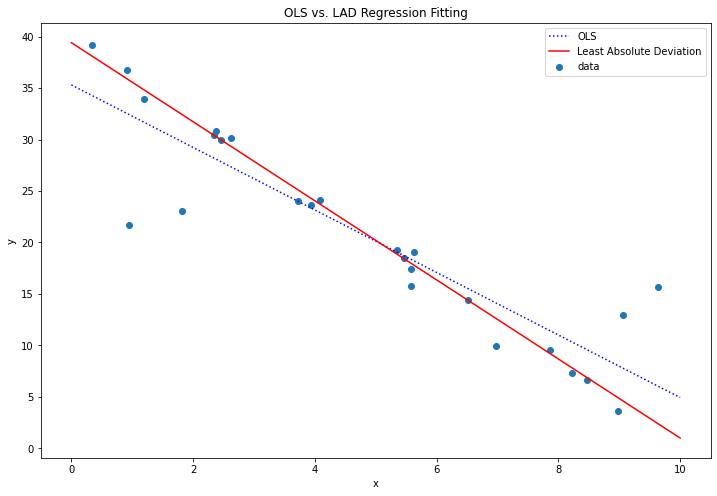

In [ ]:
leastAbsoluteDeviations()